Trial   1 at  0.1 is wrong
Trial   2 at  1.2 is wrong
Trial   3 at  1.9 is right
Trial   4 at  1.7 is right
Trial   5 at  1.7 is right


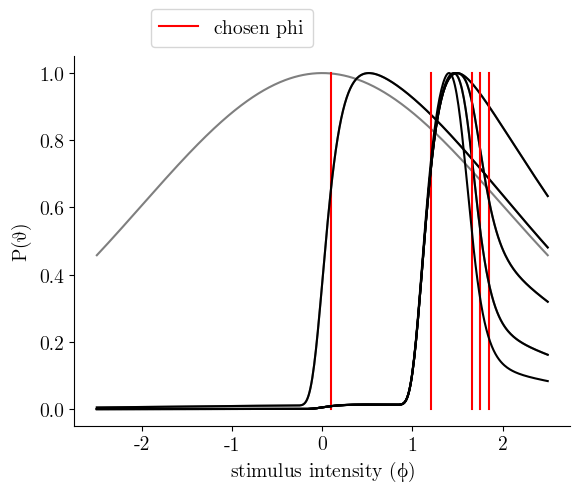

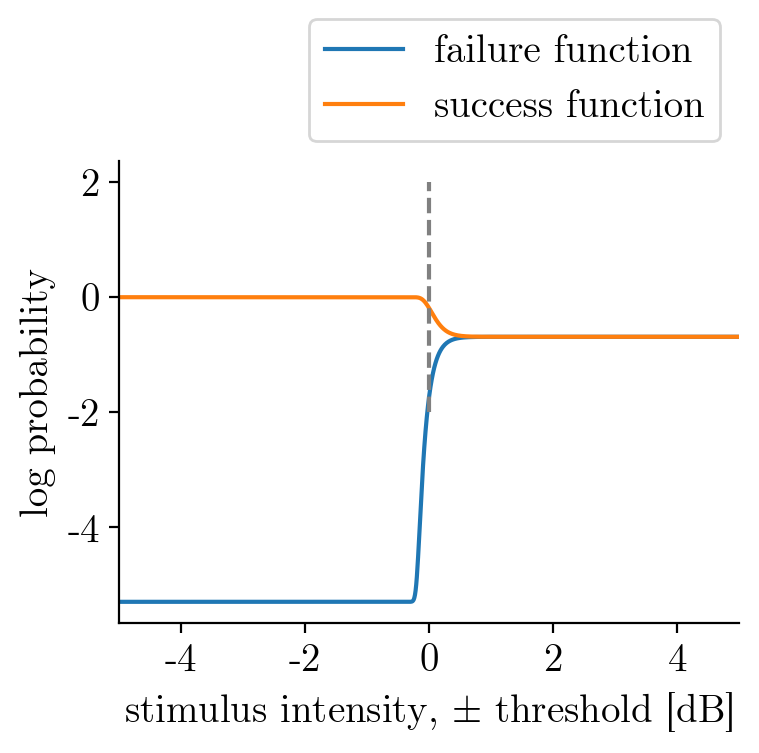

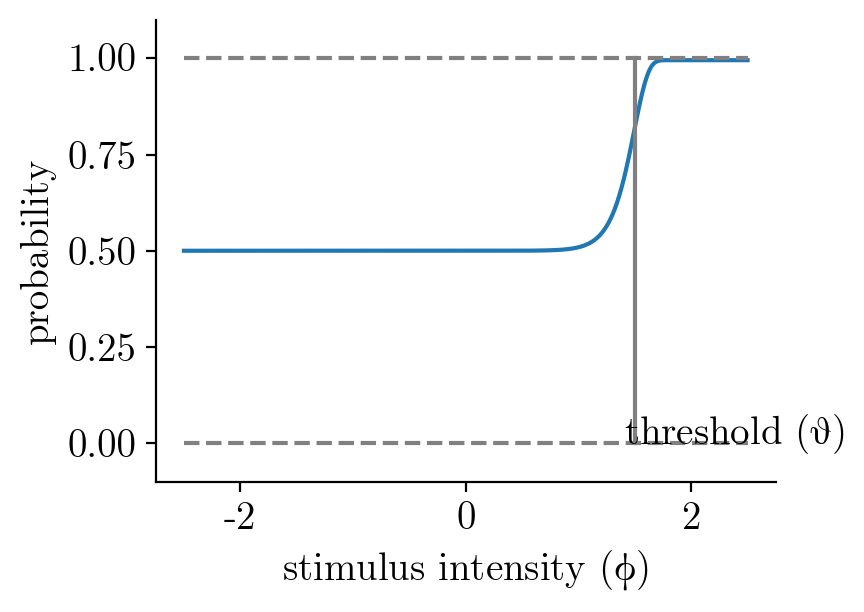

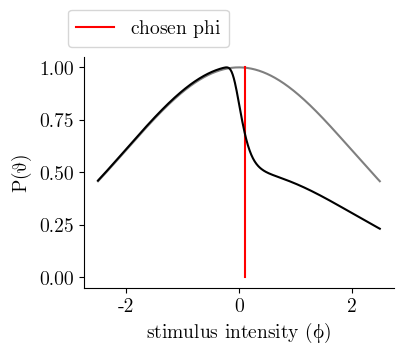

NameError: name 'q1' is not defined

In [1]:
# try to use part 2 to do same thing as quest.

from plot_ult import *
import math
def getinf(x):
    return np.nonzero( np.isinf( np.atleast_1d(x) ) )


def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx
    
'''
notations:
    phi, different intensities, as stimuli
    theta, different thresholds
    agent(theta), the psychometric function depends on threshold theta, output to a probability distribution of actions (0,1) and we randomly take one.

procedure:
    start from a gaussian prior.
    for all phi
        calculate I ~= weighted sum (var(behavior under phi and theta) for all theta). weight is the theta prior.
    use the max I phi as next stimuli.
    
'''


class QuestObject():

    def __init__(self,tGuess,tGuessSd,pThreshold,beta,delta,gamma,grain=0.01,range=None):
        super(QuestObject, self).__init__()
        grain = float(grain) # make sure grain is a float
        if range is None:
            dim = 500
        else:
            if range <= 0:
                raise ValueError('argument "range" must be greater than zero.')
            dim=range/grain
            dim=2*math.ceil(dim/2.0) # round up to even integer
        self.updatePdf = True
        self.warnPdf = True
        self.normalizePdf = False
        self.tGuess = tGuess
        self.tGuessSd = tGuessSd
        self.pThreshold = pThreshold
        self.beta = beta
        self.delta = delta
        self.gamma = gamma
        self.grain = grain
        self.dim = dim
        self.recompute()

    def mean(self):
        """Mean of Quest posterior pdf.

        Get the mean threshold estimate.

        This was converted from the Psychtoolbox's QuestMean function.
        """
        return self.tGuess + np.sum(self.pdf*self.x)/np.sum(self.pdf)

    def mode(self):
        """Mode of Quest posterior pdf.

        t,p=q.mode()
        't' is the mode threshold estimate
        'p' is the value of the (unnormalized) pdf at t.

        This was converted from the Psychtoolbox's QuestMode function.
        """
        iMode = np.argsort(self.pdf)[-1]
        p=self.pdf[iMode]
        t=self.x[iMode]+self.tGuess
        return t

    def p(self,x):
        """probability of correct response at intensity x.

        p=q.p(x)

        The probability of a correct (or yes) response at intensity x,
        assuming threshold is at x=0.

        This was converted from the Psychtoolbox's QuestP function.
        """
        if x < self.x2[0]:
            return self.x2[0]
        if x > self.x2[-1]:
            return self.x2[-1]
        return np.interp(x,self.x2,self.p2)

    def pdf_at(self,t):
        """The (unnormalized) probability density of candidate threshold 't'.

        This was converted from the Psychtoolbox's QuestPdf function.
        """
        i=int(round((t-self.tGuess)/self.grain))+1+self.dim/2
        i=min(len(self.pdf),max(1,i))-1
        p=self.pdf[int(i)]
        return p

    def quantile(self,quantileOrder=None):
        """Get Quest recommendation for next trial level.

        intensity=q.quantile([quantileOrder])

        Gets a quantile of the pdf in the struct q.  You may specify
        the desired quantileOrder, e.g. 0.5 for median, or, making two
        calls, 0.05 and 0.95 for a 90confidence interval.  If the
        'quantileOrder' argument is not supplied, then it's taken from
        the QuestObject instance. __init__() uses recompute() to
        compute the optimal quantileOrder and saves that in the
        QuestObject instance; this quantileOrder yields a quantile
        that is the most informative intensity for the next trial.

        This was converted from the Psychtoolbox's QuestQuantile function.
        """
        if quantileOrder is None:
            quantileOrder = self.quantileOrder
        p = np.cumsum(self.pdf)
        if len(getinf(p[-1])[0]):
            raise RuntimeError('pdf is not finite')
        if p[-1]==0:
            raise RuntimeError('pdf is all zero')
        m1p = np.concatenate(([-1],p))
        index = np.nonzero( m1p[1:]-m1p[:-1] )[0]
        if len(index) < 2:
            raise RuntimeError('pdf has only %g nonzero point(s)'%len(index))
        ires = np.interp([quantileOrder*p[-1]],p[index],self.x[index])[0]
        return self.tGuess+ires

    def sd(self):
        """Standard deviation of Quest posterior pdf.

        Get the sd of the threshold distribution.

        This was converted from the Psychtoolbox's QuestSd function."""
        p=np.sum(self.pdf)
        sd=math.sqrt(np.sum(self.pdf*self.x**2)/p-(np.sum(self.pdf*self.x)/p)**2)
        return sd

    def simulate(self,tTest,tActual):
        """Simulate an observer with given Quest parameters.

        response=QuestSimulate(q,intensity,tActual)

        Simulate the response of an observer with threshold tActual.

        This was converted from the Psychtoolbox's QuestSimulate function."""
        t = min( max(tTest-tActual, self.x2[0]), self.x2[-1] )
        response= np.interp([t],self.x2,self.p2)[0] > random.random()
        return response

    def simulate_p(self,tTest,tActual):
        t = min( max(tTest-tActual, self.x2[0]), self.x2[-1] ) # clip
        return np.interp([t],self.x2,self.p2)[0] # take an inteprotated value
        
    def recompute(self):
        """Recompute the psychometric function & pdf.

        Call this immediately after changing a parameter of the
        psychometric function. recompute() uses the specified
        parameters in 'self' to recompute the psychometric
        function. It then uses the newly computed psychometric
        function and the history in self.intensity and self.response
        to recompute the pdf. (recompute() does nothing if q.updatePdf
        is False.)

        This was converted from the Psychtoolbox's QuestRecompute function."""
        if not self.updatePdf:
            return
        if self.gamma > self.pThreshold:
            warnings.warn( 'reducing gamma from %.2f to 0.5'%self.gamma)
            self.gamma = 0.5
        self.i = np.arange(-self.dim/2, self.dim/2+1)
        self.x = self.i * self.grain
        self.pdf = np.exp(-0.5*(self.x/self.tGuessSd)**2)
        self.pdf = self.pdf/np.sum(self.pdf)
        i2 = np.arange(-self.dim,self.dim+1)
        self.x2 = i2*self.grain
        self.p2 = self.delta*self.gamma+(1-self.delta)*(1-(1-self.gamma)*np.exp(-10**(self.beta*self.x2)))
        if self.p2[0] >= self.pThreshold or self.p2[-1] <= self.pThreshold:
            raise RuntimeError('psychometric function range [%.2f %.2f] omits %.2f threshold'%(self.p2[0],self.p2[-1],self.pThreshold)) # XXX
        if len(getinf(self.p2)[0]):
            raise RuntimeError('psychometric function p2 is not finite')
        index = np.nonzero( self.p2[1:]-self.p2[:-1] )[0] # strictly monotonic subset
        if len(index) < 2:
            raise RuntimeError('psychometric function has only %g strictly monotonic points'%len(index))
        self.xThreshold = np.interp([self.pThreshold],self.p2[index],self.x2[index])[0]
        self.p2 = self.delta*self.gamma+(1-self.delta)*(1-(1-self.gamma)*np.exp(-10**(self.beta*(self.x2+self.xThreshold))))
        if len(getinf(self.p2)[0]):
            raise RuntimeError('psychometric function p2 is not finite')
        self.s2 = np.array( ((1-self.p2)[::-1], self.p2[::-1]) ) # wrong, right
        if not hasattr(self,'intensity') or not hasattr(self,'response'):
            self.intensity = []
            self.response = []
        if len(getinf(self.s2)[0]):
            raise RuntimeError('psychometric function s2 is not finite')

        eps = 1e-14

        pL = self.p2[0]
        pH = self.p2[-1]
        pE = pH*math.log(pH+eps)-pL*math.log(pL+eps)+(1-pH+eps)*math.log(1-pH+eps)-(1-pL+eps)*math.log(1-pL+eps)
        pE = 1/(1+math.exp(pE/(pL-pH)))
        self.quantileOrder=(pE-pL)/(pH-pL)

        if len(getinf(self.pdf)[0]):
            raise RuntimeError('prior pdf is not finite')

        # recompute the pdf from the historical record of trials
        for intensity, response in zip(self.intensity, self.response):
            inten = max(-1e10,min(1e10, intensity)) # make intensity finite
            ii = len(self.pdf) + self.i-round((inten-self.tGuess)/self.grain)-1
            if ii[0]<0:
                ii = ii-ii[0]
            if ii[-1]>=self.s2.shape[1]:
                ii = ii+self.s2.shape[1]-ii[-1]-1
            iii = ii.astype(np.int_)
            if not np.allclose(ii,iii):
                raise ValueError('truncation error')
            self.pdf = self.pdf*self.s2[response,iii]
            if self.normalizePdf and ii % 100 == 0:
                self.pdf = self.pdf/np.sum(self.pdf) # avoid underflow; keep the pdf normalized
        if self.normalizePdf:
            self.pdf = self.pdf/np.sum(self.pdf) # avoid underflow; keep the pdf normalized
        if len(getinf(self.pdf)[0]):
            raise RuntimeError('prior pdf is not finite')

    def update(self,intensity,response):
        """Update Quest posterior pdf.

        Update self to reflect the results of this trial. The
        historical records self.intensity and self.response are always
        updated, but self.pdf is only updated if self.updatePdf is
        true. You can always call QuestRecompute to recreate q.pdf
        from scratch from the historical record.

        This was converted from the Psychtoolbox's QuestUpdate function."""

        if response < 0 or response > self.s2.shape[0]:
            raise RuntimeError('response %g out of range 0 to %d'%(response,self.s2.shape[0]))
        if self.updatePdf:
            inten = max(-1e10,min(1e10,intensity)) # make intensity finite
            ii = len(self.pdf) + self.i-round((inten-self.tGuess)/self.grain)-1
            if ii[0]<0 or ii[-1] > self.s2.shape[1]:
                if self.warnPdf:
                    low=(1-len(self.pdf)-self.i[0])*self.grain+self.tGuess
                    high=(self.s2.shape[1]-len(self.pdf)-self.i[-1])*self.grain+self.tGuess
                    warnings.warn( 'intensity %.2f out of range %.2f to %.2f. Pdf will be inexact.'%(intensity,low,high),
                                   RuntimeWarning,stacklevel=2)
                if ii[0]<0:
                    ii = ii-ii[0]
                else:
                    ii = ii+self.s2.shape[1]-ii[-1]-1
            iii = ii.astype(np.int_)
            if not np.allclose(ii,iii):
                raise ValueError('truncation error')
            self.pdf = self.pdf*self.s2[response,iii]
            # plt.plot(self.x,self.s2[response,iii],label='update function')
            if self.normalizePdf:
                self.pdf=self.pdf/np.sum(self.pdf)
        # keep a historical record of the trials
        self.intensity.append(intensity)
        self.response.append(response)

    def pdf_theta(self, theta):
        self.i = np.arange(-self.dim/2, self.dim/2+1)
        self.x = self.i * self.grain
        self.pdf = np.exp(-0.5*(self.x/self.tGuessSd)**2)
        self.pdf = self.pdf/np.sum(self.pdf)

tActual = 1.5 # ground truth
tGuess = 0.1 # chance level

tGuessSd = 2.0 # sd of Gaussian before clipping to specified range
pThreshold = 0.82
beta = 3.5
delta = 0.01
gamma = 0.5
q=QuestObject(tGuess,tGuessSd,pThreshold,beta,delta,gamma)

# Simulate a series of trials.
trialsDesired=5
wrongRight = 'wrong', 'right'

for k in range(trialsDesired):
    # Get recommended level.  Choose your favorite algorithm.
    # tTest=q.quantile()
    tTest=q.mean()
    # tTest=q.mode()
    plt.plot(q.x,q.pdf/max(q.pdf), color='k', alpha=0.5)
    plt.plot([tTest,tTest],[0,max(q.pdf/max(q.pdf))], color='red', label=r'chosen $phi$')

    # tTest=tTest+random.choice([-0.1,0,0.1])

    # Simulate a trial
    response=int(q.simulate(tTest,tActual))
    print('Trial %3d at %4.1f is %s'%(k+1,tTest,wrongRight[int(response)]))

    # Update the pdf
    q.update(tTest,response)
    plt.plot(q.x,q.pdf/max(q.pdf), color='k', alpha=1)
    # plt.title(response)
    plt.xlabel(r'stimulus intensity ($\phi$)')
    plt.ylabel(r'$P(\theta)$')
    quickspine(plt.gca())
    quickleg(plt.gca(), bbox_to_anchor=(0.5,1))
    



# scucess and failure function plot --------
with initiate_plot(4,3,200) as f:
    ax=f.add_subplot(111)
    plt.plot(q.x2,np.log(q.s2[0,:]),label='failure function')
    plt.plot(q.x2,np.log(q.s2[1,:]),label='success function')
    plt.plot([0,0],[-2,2],'--', color='grey')
    plt.xlim(-5,5)
    # plt.ylim(-0.1,1.1)
    quickleg(ax, bbox_to_anchor=[1,1])
    quickspine(ax)
    plt.xlabel(r'stimulus intensity, $\pm$ threshold [dB]')
    plt.ylabel('log probability')


# psychometric function plot -------
with initiate_plot(4,3,200) as f:
    ax=f.add_subplot(111)
    plt.plot(q.x,[q.simulate_p(x, tActual) for x in q.x],label='psychometric function')
    plt.xlabel(r'stimulus intensity ($\phi$)')
    plt.ylabel('probability')
    plt.ylim(-0.1,1.1)
    plt.plot(q.x, np.zeros_like(q.x), '--', color='grey')
    plt.plot(q.x, np.ones_like(q.x), '--', color='grey')
    plt.plot([tActual,tActual],[0,1], '-', color='grey')
    plt.text(tActual-0.1,0,r'threshold ($\theta$)')
    quickspine(ax)



q=QuestObject(tGuess,tGuessSd,pThreshold,beta,delta,gamma)

# tTest=q.mean()
tTest=q.mode()
plt.plot(q.x,q.pdf/max(q.pdf), color='k', alpha=0.5)
plt.plot([tTest,tTest],[0,max(q.pdf/max(q.pdf))], color='red', label=r'chosen $phi$')
response=int(q.simulate(tTest,tActual))
q.update(tTest,response)
plt.plot(q.x,q.pdf/max(q.pdf), color='k', alpha=1)
# plt.title(response)
plt.xlabel(r'stimulus intensity ($\phi$)')
plt.ylabel(r'$P(\theta)$')
quickspine(plt.gca())
quickleg(plt.gca(), bbox_to_anchor=(0.5,1))
plt.show()

def dd(theta, phi):
    # double derivative dpsi/d2theta
    t=theta
    dd=-(k *(phi/t)**k *(1 + k + np.exp((phi/t)**k) *(-1 + k* (-1 + (phi/t)**k))))/((-1 + np.exp((phi/t)**k))**2 *t**2)    
    return dd


q=q1
Is=[]
for phi in q.x:
    # I=sum([(0.75-q.simulate_p(phi,theta))**2*priorp for priorp,theta in zip(q.pdf/sum(q.pdf),q.x)])
    # I=np.nanmean([dd(theta,phi)*priorp for priorp,theta in zip(q.pdf/sum(q.pdf),q.x)])
    # I=np.sum([(theta,phi)*priorp for priorp,theta in zip(q.pdf/sum(q.pdf),q.x)])
    psy=delta*gamma+(1-delta)*(1-(1-gamma)*np.exp(-10**(beta*(q.x))))
    I0=(np.diff(psy)**2)/((psy*(1-psy))[1:]) # information of delta phi-theta, the kernel
    priortheta=q.pdf/sum(q.pdf)
    conv=np.convolve(priortheta,I0)[len(q.x)//2:-(len(q.x)//2)]
    I=np.sum(conv
             )
    # plt.plot(conv)
    # len(conv)
    # len(priortheta)
    # len(I0)
    # psy=delta*gamma+(1-delta)*(1-(1-gamma)*np.exp(-10**(beta*(q.x))))
    # plt.plot(psy)
    # plt.plot(I0)

    # phi=-1
    # # plt.plot(q.x, dd(q.x,phi))
    # plt.plot(q.x, q.pdf/sum(q.pdf))
    # plt.plot(q.x, dd(q.x,phi)*q.pdf/sum(q.pdf))
    # # plt.plot(q.x,[dd(theta,phi) for priorp,theta in zip(q.pdf/sum(q.pdf),q.x)])
    # plt.plot(q.x,[priorp for priorp,theta in zip(q.pdf/sum(q.pdf),q.x)])
    # plt.plot(q.x,[dd(theta,phi)*priorp for priorp,theta in zip(q.pdf/sum(q.pdf),q.x)])

    Is.append(I)
psy=delta*gamma+(1-delta)*(1-(1-gamma)*np.exp(-10**(beta*(q.x))))
I0=(np.diff(psy)**2)/((psy*(1-psy))[1:]) # information of delta phi-theta, the kernel
priortheta=q.pdf/sum(q.pdf)
conv=np.convolve(priortheta,I0)[len(q.x)//2:-(len(q.x)//2)]
bestphi=q.x[np.argmax(conv)]



# current theta estimation
plt.plot(q.x,q.pdf/max(q.pdf))
plt.xlabel(r'threshold $\theta$')
plt.ylabel(r'current $P(\theta|data)$')
plt.title(r'QUEST: mode $\theta$={:.2f}'.format(q.mode()))
plt.plot([q.mode(),q.mode()],[0,1], '--', color='grey')
quickspine(plt.gca())
plt.show()

# best phi--------
psy=delta*gamma+(1-delta)*(1-(1-gamma)*np.exp(-10**(beta*(q.x))))
I0=(np.diff(psy)**2)/((psy*(1-psy))[1:])
priortheta=q.pdf/sum(q.pdf)
conv=np.convolve(priortheta,I0)[len(q.x)//2:-(len(q.x)//2-1)]
bestphi=q.x[np.argmax(conv)]
plt.plot(q.x,conv)
plt.plot([bestphi,bestphi],[min(conv), max(conv)], '--', color='grey')
plt.xlabel(r'stimulus $\phi$')
plt.ylabel(r'optimization criterion')
plt.title(r'our: best $\phi$={:.2f}'.format(bestphi))
quickspine(plt.gca())





# compare
tActual = 1 # ground truth
tGuess = 0.0 # chance level
tGuessSd = 2.0 # sd of Gaussian before clipping to specified range
pThreshold = 0.82
beta = 3.5
delta = 0.01
gamma = 0.5

# compare how many steps need to converge
q1=QuestObject(tGuess,tGuessSd,pThreshold,beta,delta,gamma)
q2=QuestObject(tGuess,tGuessSd,pThreshold,beta,delta,gamma)
phis1=[]
phis2=[]
noise=0.05
for i in range(55):
    # q1 update
    tTest=q1.mean()
    # tTest=q1.quantile()
    tTest=tTest+(np.random.normal()*noise)
    response=int(q1.simulate(tTest,tActual))
    q1.update(tTest,response)
    phis1.append(tTest)

    # # q2 update
    # Is=[]
    # for i,phi in enumerate(q2.x):
    #     # I=sum([(0.796-q2.simulate_p(phi,theta))**2*priorp for priorp,theta in zip(q2.pdf/sum(q2.pdf),q2.x)])
    #     I=np.nansum([dd(theta,phi)*priorp for priorp,theta in zip(q.pdf/sum(q.pdf),q.x)])
    #     Is.append(I)
    # tTest=q2.x[np.argmin(Is)]
    # tTest=tTest+(np.random.normal()*noise)
    # response=int(q2.simulate(tTest,tActual))
    # q2.update(tTest,response)
    # phis2.append(tTest)

    # q2 update 0504
    psy0=delta*gamma+(1-delta)*(1-(1-gamma)*np.exp(-10**(beta*(q2.x))))
    I0=(np.diff(psy0)**2)/((psy0*(1-psy0))[1:])
    priortheta=q2.pdf/sum(q2.pdf)
    conv=np.convolve(priortheta,I0)[len(q2.x)//2:-(len(q2.x)//2-1)]
    # plt.plot(q.x,psy)
    # plt.plot(q.x[1:],I0)
    # plt.plot(q.x,conv)
    tTest=q2.x[np.argmax(conv)] # selected best phi
    tTest=tTest+(np.random.normal()*noise)
    response=int(q2.simulate(tTest,tActual))
    q2.update(tTest,response)
    phis2.append(tTest)
    
with initiate_plot(9,3,200) as f:
    ax1=f.add_subplot(131)
    ax2=f.add_subplot(132, sharey=ax1)
    ax1.set_ylabel('phi')
    ax1.set_xlabel('steps')
    ax2.set_xlabel('steps')
    ax1.set_title('quest')
    ax2.set_title('our')
    quickspine(ax1)
    quickspine(ax2)
    ax1.plot(list(range(len(phis1))), phis1)
    ax2.plot(list(range(len(phis2))), phis2, color='orange')

    ax3=f.add_subplot(133,sharey=ax1)
    quickspine(ax3)
    ax3.plot(list(range(len(phis2))), [tActual]*len(phis1), color='black')
    ax3.plot(list(range(len(phis1))), phis1)
    ax3.plot(list(range(len(phis2))), phis2)


# compare the best phi given same history
phis1=[]
phis2=[]
noise=0.05
for tActual in np.linspace(-2,2,100): # number of tasks
    q1=QuestObject(tGuess,tGuessSd,pThreshold,beta,delta,gamma)
    for i in range(55): # number of trials per task
        # quest selection
        tTest=q1.mean()
        # tTest=q1.quantile()
        # tTest=q1.mode()
        phis1.append(tTest)

        # our selection
        psy0=delta*gamma+(1-delta)*(1-(1-gamma)*np.exp(-10**(beta*(q1.x))))
        I0=(np.diff(psy0)**2)/((psy0*(1-psy0))[1:])
        priortheta=q1.pdf/sum(q1.pdf)
        conv=np.convolve(priortheta,I0)[len(q1.x)//2:-(len(q1.x)//2-1)]
        tTest2=q1.x[np.argmax(conv)] # selected best phi
        phis2.append(tTest2)
    
        tTest=tTest+(np.random.normal()*noise)
        response=int(q1.simulate(tTest,tActual))
        q1.update(tTest,response)
        
with initiate_plot(3,3,200) as f:
    ax1=f.add_subplot(111)
    ax1.set_ylabel('quest phi')
    ax1.set_xlabel('our phi')
    ax1.set_title('quest(mean) vs our phi')
    ax1.scatter(phis2,phis1, s=0.1)
    plt.axis('equal')
    plt.xlim([-2,2])
    ax1.plot([-2.5,2.5],[-2.5,2.5], color='black')



q1=QuestObject(tGuess,tGuessSd,pThreshold,beta,delta,gamma)
q2=QuestObject(tGuess,tGuessSd,pThreshold,beta,delta,gamma)
with initiate_plot(7,3,200) as f:
    ax1=f.add_subplot(1,2,1)
    ax2=f.add_subplot(1,2,2)

    ax1.plot(q1.x,q1.pdf/max(q1.pdf), color='k', alpha=0.5)

    # q1 update
    tTest=q1.quantile()
    tTest=tTest+(np.random.normal()*noise)
    response=int(q1.simulate(tTest,tActual))
    print('Trial %3d at %4.1f is %s'%(k+1,tTest,wrongRight[int(response)]))
    q1.update(tTest,response)

    ax1.plot([tTest,tTest],[0,max(q1.pdf/max(q1.pdf))], color='red', label=r'chosen $phi$')
    ax1.plot(q1.x,q1.pdf/max(q1.pdf), color='k', alpha=1)
    ax1.set_title('resp={},QUEST phi={:.2f}'.format(response,tTest))
    ax1.set_xlabel(r'stimulus intensity ($\phi$)')
    ax1.set_ylabel(r'$P(\theta)$')
    quickspine(ax1)


    ax2.plot(q2.x,q2.pdf/max(q2.pdf), color='k', alpha=0.5)
    # # q2 update
    # Is=[]
    # for phi in q2.x:
    #     I=sum([(0.75-q2.simulate_p(phi,theta))**2*priorp for priorp,theta in zip(q2.pdf/sum(q2.pdf),q2.x)])
    #     Is.append(I)
    # tTest=q2.x[np.argmin(Is)]
    # tTest=tTest+(np.random.normal()*noise)
    # response=int(q2.simulate(tTest,tActual))
    # q2.update(tTest,response)

    # q2 update 0504
    psy0=delta*gamma+(1-delta)*(1-(1-gamma)*np.exp(-10**(beta*(q2.x))))
    I0=(np.diff(psy0)**2)/((psy0*(1-psy0))[1:])
    priortheta=q2.pdf/sum(q2.pdf)
    conv=np.convolve(priortheta,I0)[len(q2.x)//2:-(len(q2.x)//2-1)]
    # plt.plot(q.x,psy)
    # plt.plot(q.x[1:],I0)
    # plt.plot(q.x,conv)
    tTest=q2.x[np.argmax(conv)] # selected best phi
    tTest=tTest+(np.random.normal()*noise)
    response=int(q2.simulate(tTest,tActual))
    q2.update(tTest,response)



    ax2.plot([tTest,tTest],[0,max(q2.pdf/max(q2.pdf))], color='red', label=r'chosen $phi$')
    ax2.plot(q2.x,q2.pdf/max(q2.pdf), color='k', alpha=1)
    ax2.set_title('resp={},our phi={:.2f}'.format(response,tTest))
    ax2.set_xlabel(r'stimulus intensity ($\phi$)')
    ax2.set_ylabel(r'$P(\theta)$')
    quickspine(ax2)
    quickleg(ax2, bbox_to_anchor=(1,1.2))


p=np.linspace(0,1,22)
plt.plot(p*(1-p))






plt.plot(q.x,[abs(0.75-q.simulate_p(0,theta))*priorp for priorp,theta in zip(q.pdf/sum(q.pdf),q.x)])

sum([(0.75-q.simulate_p(0,theta))**2*priorp for priorp,theta in zip(q.pdf/sum(q.pdf),q.x)])
sum([(0.75-q.simulate_p(1.5,theta))**2*priorp for priorp,theta in zip(q.pdf/sum(q.pdf),q.x)])



Simulating 5 trials with individual PDF plots...


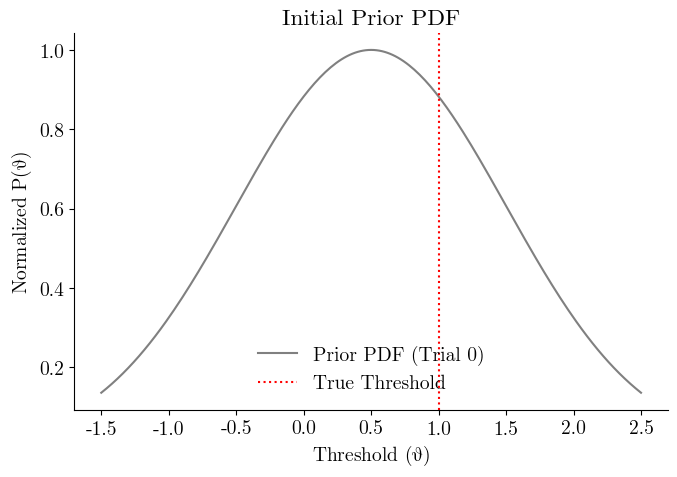

Trial   1 at  0.500 is Incorrect


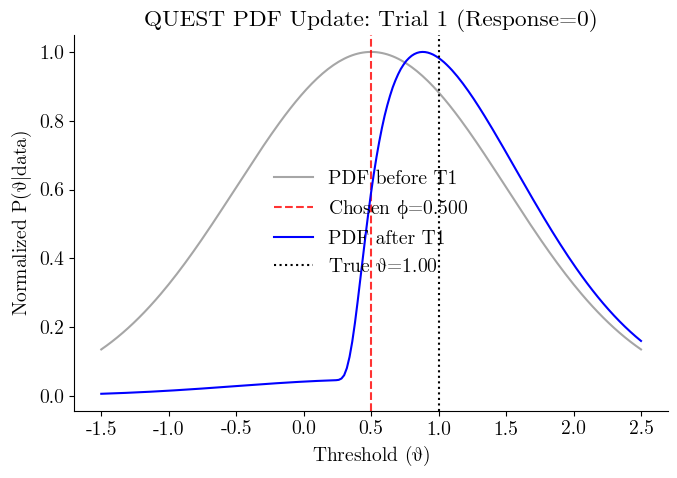

Trial   2 at  1.183 is Correct


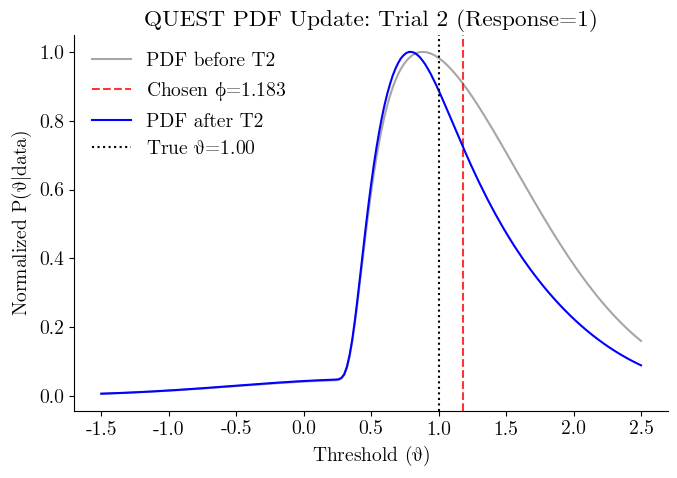

Trial   3 at  1.068 is Correct


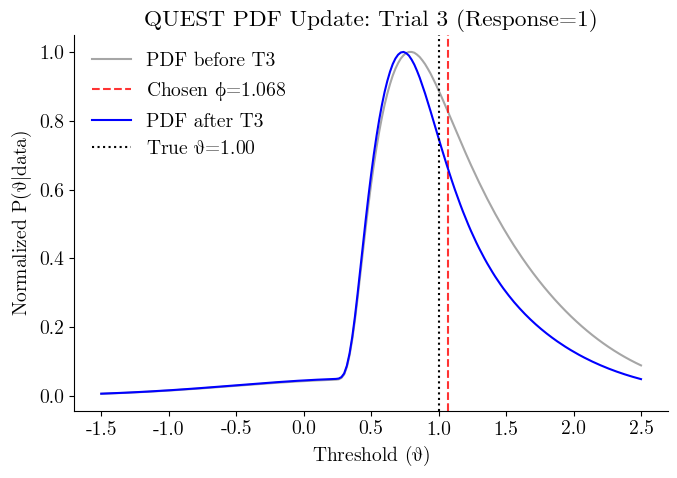

Trial   4 at  0.958 is Correct


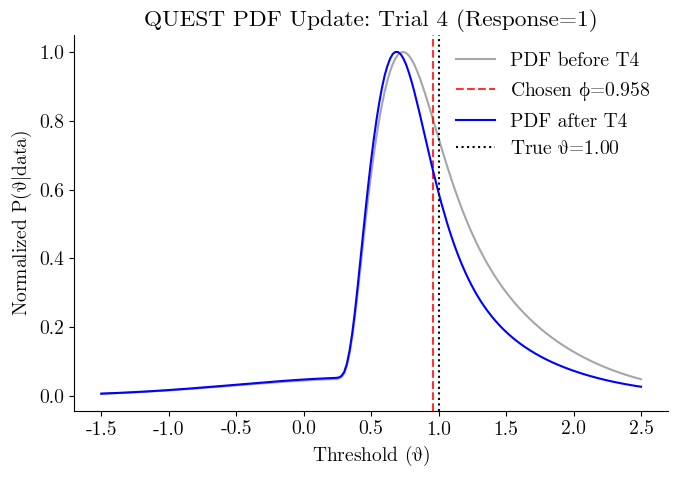

Trial   5 at  0.854 is Incorrect


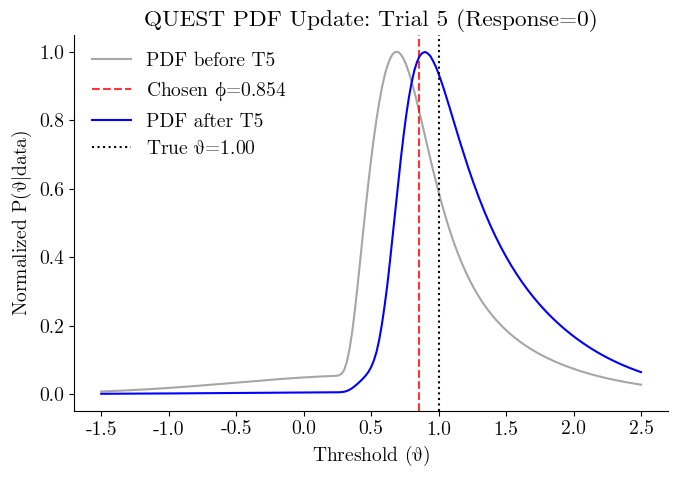

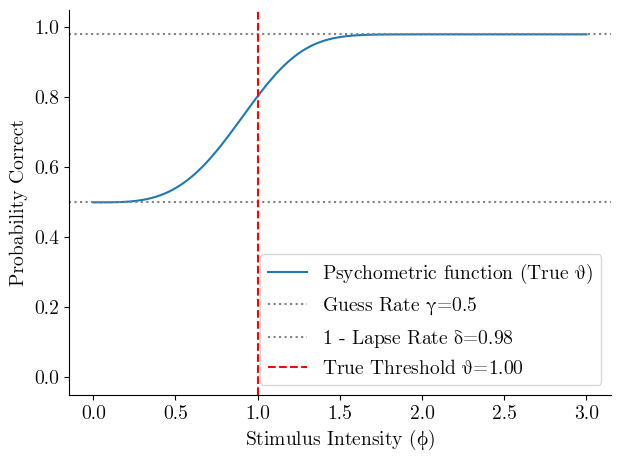


--- Comparing QUEST (Mean) vs Custom (Max Info) Selection ---

Finished 50 comparison trials.


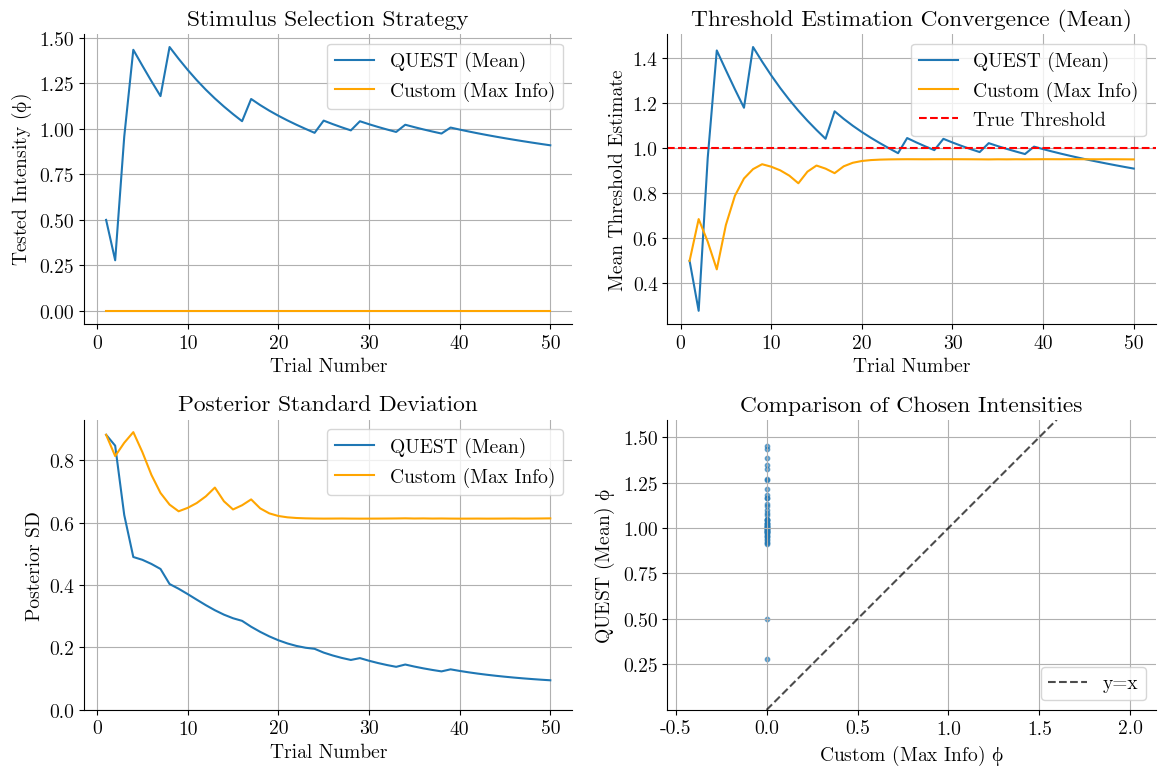

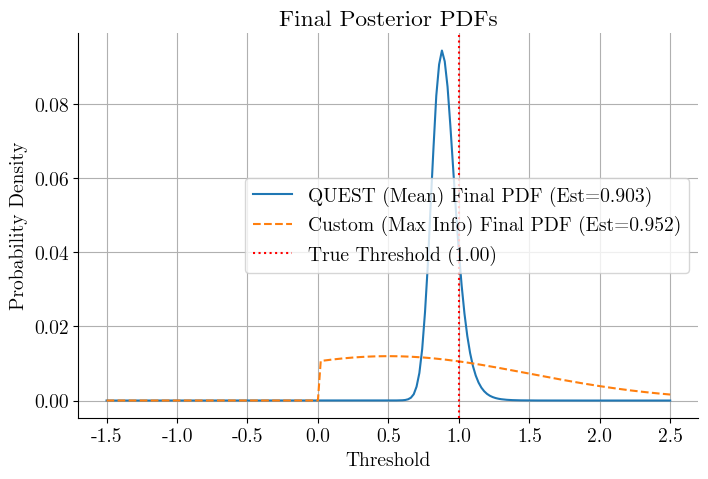


Comparison simulation complete.


In [3]:
import numpy as np
import math
import copy
import warnings
import random
import sys
import time
import matplotlib.pyplot as plt
from scipy.stats import norm
# Assuming QuestObject class is defined as in the artifact 'quest_class_fix'
# If not, you need to include the corrected QuestObject class definition here.
# from quest_class_fix import QuestObject # Example if it was in a separate file

# --- Make sure QuestObject is defined before this point ---
# Helper to check for np.inf, np.nan - np.isfinite covers both
def getinf(x):
    return np.nonzero(~np.isfinite(np.atleast_1d(x)))[0]

class QuestObject():
    """
    Measure threshold using a Weibull psychometric function via the QUEST method.
    (Using the corrected version from quest_class_fix artifact)
    """
    def __init__(self, tGuess, tGuessSd, pThreshold, beta, delta, gamma, grain=0.01, range=None, verbose=False):
        """Initialize Quest parameters."""
        super(QuestObject, self).__init__()
        if tGuess <= 0:
             raise ValueError("tGuess must be positive.")
        if tGuessSd <= 0:
             raise ValueError("tGuessSd must be positive.")
        if not (0 < pThreshold < 1):
            raise ValueError("pThreshold must be between 0 and 1.")
        if beta <= 0:
            raise ValueError("beta must be positive.")
        if not (0 <= gamma < 1):
            raise ValueError("gamma must be between 0 and 1.")
        if not (0 <= delta < 1):
            raise ValueError("delta must be between 0 and 1.")
        if gamma + delta >= 1:
             raise ValueError("Sum of gamma and delta must be less than 1.")
        if grain <= 0:
             raise ValueError("grain must be positive.")

        self.grain = float(grain) # Ensure float
        if range is None:
            # Heuristic based on sd: cover +/- 5 standard deviations
            self.range = 10.0 * tGuessSd
            self.dim = int(round(self.range / self.grain))
        else:
            if range <= 0:
                raise ValueError('argument "range" must be greater than zero.')
            self.range = range
            self.dim = int(round(self.range / self.grain))

        # Ensure dim is even and reasonably large
        self.dim = max(2 * math.ceil(self.dim / 2.0), 100) # Round up to even, min size 100
        self.range = self.dim * self.grain # Adjust range slightly based on final dim/grain

        self.updatePdf = True
        self.warnPdf = True
        self.normalizePdf = True # <<< Changed default to True for stability >>>
        self.verbose = verbose

        self.tGuess = tGuess
        self.tGuessSd = tGuessSd
        self.pThreshold = pThreshold
        self.beta = beta
        self.delta = delta
        self.gamma = gamma

        self.intensity = [] # History
        self.response = []  # History

        self.recompute() # Initialize pdf, psychometric function, etc.

    def weibull_psychometric_instance(self, intensity, threshold):
        """
        Internal helper to use instance parameters for the psychometric function.
        P(correct) = gamma + (1 - gamma - delta) * (1 - exp(-(intensity/threshold)**beta))
        """
        intensity = np.maximum(intensity, 1e-9)
        threshold = np.maximum(threshold, 1e-9)
        prob_detect = 1.0 - np.exp(-(intensity / threshold)**self.beta)
        p_correct = self.gamma + (1.0 - self.gamma - self.delta) * prob_detect
        return np.clip(p_correct, self.gamma, 1.0 - self.delta)

    def recompute(self):
        """Recompute the psychometric function lookup table and the posterior pdf."""
        if not self.updatePdf and hasattr(self, 'pdf'):
            return
        if self.verbose: print("Recomputing internal state...")

        # Initialize PDF
        self.i = np.arange(-self.dim / 2, self.dim / 2 + 1)
        self.x = self.i * self.grain
        self.pdf = norm.pdf(self.x, loc=0, scale=self.tGuessSd)
        pdf_sum = np.sum(self.pdf)
        if pdf_sum < 1e-9:
             warnings.warn(f"Prior PDF sum is near zero ({pdf_sum:.2E}). Resetting to uniform.", RuntimeWarning)
             self.pdf = np.ones_like(self.x)
        self.pdf = self.pdf / np.sum(self.pdf)

        # Precompute Psychometric Function Lookup (assuming log intensity axis for internal function)
        self.x2_dim = 2 * self.dim
        self.i2 = np.arange(-self.x2_dim / 2, self.x2_dim / 2 + 1)
        self.x2 = self.i2 * self.grain

        # Calculate xThreshold assuming log intensity axis
        target_for_log = 1.0 - (self.pThreshold - self.gamma) / (1.0 - self.gamma - self.delta)
        if target_for_log <= 0 or target_for_log >= 1:
             raise ValueError("pThreshold is outside the range achievable by the psychometric function.")
        log_target = -np.log(target_for_log)
        if log_target < 0:
             raise ValueError("Internal log target is negative, check parameters.")
        # Add small epsilon to prevent potential issues with log_target being exactly zero if pThreshold = 1-(1-gamma-delta)
        exp_term_base = (log_target + 1e-12)**(1.0 / self.beta)
        self.xThreshold = np.log10(exp_term_base)

        if self.verbose: print(f"Recalculated xThreshold (log scale) = {self.xThreshold:.4f}")

        # Calculate final p2 lookup table using the log-scale interpretation
        exponent_arg = self.beta * (self.x2 + self.xThreshold)
        exponent_arg = np.clip(exponent_arg, -50, 50)
        weibull_term = np.exp(- (10**exponent_arg))
        self.p2 = self.gamma + (1.0 - self.gamma - self.delta) * (1.0 - weibull_term)
        self.p2 = np.clip(self.p2, self.gamma, 1.0 - self.delta)

        if len(getinf(self.p2)) > 0:
            raise RuntimeError('psychometric function p2 is not finite after log scale calculation')

        self.s2 = np.vstack((1.0 - self.p2, self.p2))
        if len(getinf(self.s2)) > 0:
            raise RuntimeError('psychometric function s2 is not finite')

        # Default quantileOrder
        self.quantileOrder = 0.5
        if self.verbose: print(f"Using default quantileOrder = {self.quantileOrder}")

        # Recompute the pdf from the historical record of trials
        if hasattr(self, 'intensity') and len(self.intensity) > 0:
            if self.verbose: print(f"Recomputing PDF from {len(self.intensity)} historical trials...")
            # Start from prior
            temp_pdf = norm.pdf(self.x, loc=0, scale=self.tGuessSd)
            temp_pdf = temp_pdf / np.sum(temp_pdf)

            for k_hist, (inten, resp) in enumerate(zip(self.intensity, self.response)):
                abs_thresholds_k = self.tGuess + self.x
                abs_thresholds_k = np.maximum(abs_thresholds_k, 1e-9)
                log_thresholds_k = np.log10(abs_thresholds_k)
                log_intensity = np.log10(np.maximum(inten, 1e-9))
                x2_values_for_update = log_intensity - log_thresholds_k
                likelihood_k = np.interp(x2_values_for_update, self.x2, self.s2[resp, :])
                temp_pdf = temp_pdf * likelihood_k

                # Normalize periodically or if sum gets too small
                pdf_sum = np.sum(temp_pdf)
                if pdf_sum < 1e-9 or (self.normalizePdf and (k_hist + 1) % 10 == 0) :
                    if pdf_sum < 1e-9:
                         warnings.warn(f"PDF sum near zero during recompute trial {k_hist+1}. Resetting.", RuntimeWarning)
                         temp_pdf = np.ones_like(self.x) / len(self.x) # Reset to uniform if collapsed
                    else:
                         temp_pdf = temp_pdf / pdf_sum # Normalize otherwise

            # Final normalization and assignment
            pdf_sum = np.sum(temp_pdf)
            if pdf_sum < 1e-9:
                 warnings.warn("Final PDF sum near zero after recompute. Resetting.", RuntimeWarning)
                 self.pdf = np.ones_like(self.x) / len(self.x)
            else:
                 self.pdf = temp_pdf / pdf_sum

        if len(getinf(self.pdf)) > 0:
            raise RuntimeError('pdf is not finite after recompute')
        if self.verbose: print("Recompute complete.")


    def update(self, intensity, response):
        """Update Quest posterior pdf."""
        if response not in [0, 1]:
            raise ValueError(f'response {response} out of range [0, 1]')

        # Always keep a historical record
        self.intensity.append(intensity)
        self.response.append(int(response)) # Ensure response is integer 0 or 1

        if self.updatePdf:
            # Calculate likelihood P(response | intensity, theta_k) for all theta_k in grid
            abs_thresholds_k = self.tGuess + self.x
            abs_thresholds_k = np.maximum(abs_thresholds_k, 1e-9) # Ensure > 0
            log_thresholds_k = np.log10(abs_thresholds_k)

            log_intensity = np.log10(np.maximum(intensity, 1e-9)) # Ensure > 0

            # Calculate relative log intensity for each possible threshold theta_k
            x2_values_for_update = log_intensity - log_thresholds_k

            # Check if x2 values are within the lookup range (self.x2)
            min_x2, max_x2 = self.x2[0], self.x2[-1]
            if np.any(x2_values_for_update < min_x2) or np.any(x2_values_for_update > max_x2):
                 if self.warnPdf:
                     warnings.warn(
                         f'Effective relative log intensity {np.min(x2_values_for_update):.2f} to {np.max(x2_values_for_update):.2f} '
                         f'partially outside lookup range [{min_x2:.2f}, {max_x2:.2f}] for tested intensity {intensity:.3f}. Pdf might be less accurate.',
                         RuntimeWarning, stacklevel=2
                     )
                 # Clamp values to the edge of the lookup table range for interpolation
                 x2_values_for_update = np.clip(x2_values_for_update, min_x2, max_x2)

            # Interpolate likelihoods P(response | intensity, theta_k) from self.s2
            # self.s2[0,:] is P(wrong | x2)
            # self.s2[1,:] is P(correct | x2)
            likelihood_k = np.interp(x2_values_for_update, self.x2, self.s2[int(response), :])

            # Update pdf: Posterior = Prior * Likelihood
            self.pdf = self.pdf * likelihood_k

            # Normalize to prevent underflow/overflow and keep it a distribution
            pdf_sum = np.sum(self.pdf)
            if pdf_sum < 1e-9: # Check for potential underflow
                 warnings.warn(f"PDF sum near zero after update. Check parameters/likelihood. Resetting PDF to uniform.", RuntimeWarning)
                 self.pdf = np.ones_like(self.x) / len(self.x) # Reset to uniform
            else:
                 self.pdf = self.pdf / pdf_sum # Normalize

            if len(getinf(self.pdf)) > 0:
                 raise RuntimeError(f'pdf is not finite after update')

    def mean(self):
        """Mean of Quest posterior pdf (estimated threshold)."""
        abs_threshold_grid = self.tGuess + self.x
        pdf_sum = np.sum(self.pdf)
        # Use current pdf directly if sum is okay, otherwise normalize copy
        current_pdf = self.pdf
        if abs(pdf_sum - 1.0) > 1e-6:
             if pdf_sum > 1e-9:
                 # warnings.warn(f"PDF sum is {pdf_sum:.4f}, should be 1. Normalizing before mean calculation.", RuntimeWarning)
                 current_pdf = self.pdf / pdf_sum
             else:
                  # warnings.warn("PDF sum is near zero, cannot compute mean reliably. Returning tGuess.", RuntimeWarning)
                  return self.tGuess # Avoid NaN if pdf collapsed

        return np.sum(current_pdf * abs_threshold_grid)

    def sd(self):
        """Standard deviation of Quest posterior pdf."""
        pdf_sum = np.sum(self.pdf)
        current_pdf = self.pdf
        if abs(pdf_sum - 1.0) > 1e-6:
            if pdf_sum > 1e-9:
                # warnings.warn(f"PDF sum is {pdf_sum:.4f}, should be 1. Normalizing before SD calculation.", RuntimeWarning)
                current_pdf = self.pdf / pdf_sum
            else:
                # warnings.warn("PDF sum is near zero, cannot compute SD reliably. Returning Inf.", RuntimeWarning)
                return np.inf # Return Inf SD if pdf collapsed

        abs_threshold_grid = self.tGuess + self.x
        mean_val = np.sum(current_pdf * abs_threshold_grid)
        variance = np.sum(current_pdf * (abs_threshold_grid**2)) - mean_val**2
        return math.sqrt(max(0, variance)) # Ensure non-negative variance

    def mode(self):
        """Mode of Quest posterior pdf."""
        iMode = np.argmax(self.pdf) # Index of the maximum value
        p = self.pdf[iMode]
        t = self.x[iMode] + self.tGuess # Absolute threshold value
        return t, p # Return threshold and probability density

    def quantile(self, quantileOrder=None):
        """Get Quest recommendation for next trial intensity (quantile of the pdf)."""
        if quantileOrder is None:
            quantileOrder = self.quantileOrder # Use pre-calculated optimal/default quantile

        pdf_sum = np.sum(self.pdf)
        if pdf_sum < 1e-9:
             warnings.warn("PDF sum is near zero, cannot compute quantile. Returning tGuess.", RuntimeWarning)
             return self.tGuess
        # Use current pdf directly if sum is okay, otherwise normalize copy
        current_pdf = self.pdf
        if abs(pdf_sum - 1.0) > 1e-6:
             # warnings.warn(f"PDF sum is {pdf_sum:.4f}, should be 1. Normalizing before quantile calculation.", RuntimeWarning)
             current_pdf = self.pdf / pdf_sum

        # Calculate cumulative distribution function (CDF)
        cdf = np.cumsum(current_pdf)

        # Find the indices where the CDF crosses the target quantile
        # Use interpolation to find the threshold value corresponding to the quantile
        try:
            # np.interp needs monotonically increasing x values (cdf)
            # Find unique CDF values and their corresponding thresholds
            unique_cdf, unique_idx = np.unique(cdf, return_index=True)
            abs_threshold_grid = self.tGuess + self.x
            unique_thresholds = abs_threshold_grid[unique_idx]

            if len(unique_cdf) < 2: # Handle case where PDF is concentrated at one point
                 quantile_threshold = unique_thresholds[0]
            else:
                 # Ensure quantileOrder is within the range of unique_cdf
                 interp_quantile = np.clip(quantileOrder, unique_cdf[0], unique_cdf[-1])
                 quantile_threshold = np.interp(interp_quantile, unique_cdf, unique_thresholds)

        except Exception as e:
             warnings.warn(f"Quantile interpolation failed: {e}. Returning mean.", RuntimeWarning)
             quantile_threshold = self.mean() # Fallback to mean

        return quantile_threshold


    def simulate(self, tTest, tActual):
        """Simulate an observer's response for intensity tTest given true threshold tActual."""
        pCorrect = self.weibull_psychometric_instance(tTest, tActual)
        response = int(np.random.rand() < pCorrect) # 1 if rand < pCorrect, else 0
        return response

    # Added simulate_p based on user code, using the instance method
    def simulate_p(self, tTest, tActual):
        """Calculate probability of correct response for intensity tTest given true threshold tActual."""
        return self.weibull_psychometric_instance(tTest, tActual)

    def beta_analysis(self, stream=None):
        """Analyze the quest function with beta as a free parameter."""
        print('Beta analysis requires careful validation and is currently disabled in this corrected version.')
        return None, None

# =============================================================================
# Helper Functions (Replacing plot_ult)
# =============================================================================

def quickspine(ax):
    """Removes top and right spines."""
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

def quickleg(ax, **kwargs):
    """Adds a legend with some default styling."""
    # Combine default legend arguments with user-provided ones
    default_kwargs = {'frameon': False}
    combined_kwargs = {**default_kwargs, **kwargs}
    leg = ax.legend(**combined_kwargs)
    # if leg: # legend() returns None if nothing to label
    #     leg.get_frame().set_linewidth(0.0) # frameon=False does this

# =============================================================================
# Main Script Logic
# =============================================================================

# --- Parameters ---
tActual = 1.0 # Ground truth threshold
tGuess = 0.5  # Initial guess (must be > 0)
tGuessSd = 1.0 # SD of Gaussian prior (adjust based on expected range)
pThreshold = 0.75 # Target performance for threshold definition
beta = 3.5       # Weibull slope
delta = 0.02     # Lapse rate
gamma = 0.5      # Guess rate (e.g., 2AFC)
grain = 0.02     # Resolution of threshold grid relative to tGuess
quest_range = 4.0  # Range around tGuess for threshold grid

# --- Instantiate ---
try:
    q=QuestObject(tGuess,tGuessSd,pThreshold,beta,delta,gamma, grain=grain, range=quest_range)
except Exception as e:
    print(f"Error initializing QuestObject: {e}")
    sys.exit()

# --- Simulate a few trials and plot PDF evolution ---
trialsDesired=5
wrongRight = 'Incorrect', 'Correct' # More descriptive labels

print(f"\nSimulating {trialsDesired} trials with individual PDF plots...")

# Plot initial prior
plt.figure(figsize=(7, 5))
plt.plot(q.tGuess + q.x, q.pdf/np.max(q.pdf), color='grey', alpha=1.0, label='Prior PDF (Trial 0)')
plt.axvline(tActual, color='r', linestyle=':', label='True Threshold')
plt.xlabel(r'Threshold ($\theta$)')
plt.ylabel(r'Normalized $P(\theta)$')
plt.title('Initial Prior PDF')
quickspine(plt.gca())
quickleg(plt.gca())
plt.tight_layout()
plt.show()


for k in range(trialsDesired):
    # --- Create a new figure for this trial's update ---
    fig_trial, ax_trial = plt.subplots(figsize=(7, 5))

    # 1. Plot PDF *before* update
    pdf_before = q.pdf.copy() # Make a copy
    max_pdf_before = np.max(pdf_before)
    if max_pdf_before < 1e-9: max_pdf_before = 1.0 # Avoid division by zero if pdf collapsed
    ax_trial.plot(q.tGuess + q.x, pdf_before / max_pdf_before, color='grey', alpha=0.7, label=f'PDF before T{k+1}')

    # 2. Get recommended level
    tTest=q.mean() # Use mean for stimulus selection
    tTest = max(tTest, 1e-9) # Ensure positive intensity
    ax_trial.axvline(tTest, color='red', linestyle='--', alpha=0.8, label=f'Chosen $\phi$={tTest:.3f}')

    # 3. Simulate a trial
    response=int(q.simulate(tTest,tActual))
    print('Trial %3d at %6.3f is %s'%(k+1, tTest, wrongRight[response]))

    # 4. Update the pdf
    q.update(tTest,response)

    # 5. Plot PDF *after* update
    pdf_after = q.pdf.copy()
    max_pdf_after = np.max(pdf_after)
    if max_pdf_after < 1e-9: max_pdf_after = 1.0 # Avoid division by zero
    ax_trial.plot(q.tGuess + q.x, pdf_after / max_pdf_after, color='blue', alpha=1.0, label=f'PDF after T{k+1}')

    # --- Add plot details ---
    ax_trial.axvline(tActual, color='k', linestyle=':', label=f'True $\\theta$={tActual:.2f}')
    ax_trial.set_xlabel(r'Threshold ($\theta$)')
    ax_trial.set_ylabel(r'Normalized $P(\theta|data)$')
    ax_trial.set_title(f'QUEST PDF Update: Trial {k+1} (Response={response})')
    quickspine(ax_trial)
    quickleg(ax_trial)
    plt.tight_layout()
    plt.show() # Show plot for this trial


# --- Psychometric function plot (remains the same) ---
plt.figure(figsize=(7, 5))
ax_psy = plt.gca()
plot_thresholds = q.tGuess + q.x # Absolute thresholds on grid
plot_intensities = np.linspace(min(plot_thresholds)*0.8, max(plot_thresholds)*1.2, 200)
plot_intensities = np.maximum(plot_intensities, 1e-9) # Ensure positive
# Calculate P(correct) for a fixed threshold (e.g., true threshold) across intensities
p_correct_plot = q.weibull_psychometric_instance(plot_intensities, tActual)
ax_psy.plot(plot_intensities, p_correct_plot, label='Psychometric function (True $\\theta$)')
ax_psy.set_xlabel(r'Stimulus Intensity ($\phi$)')
ax_psy.set_ylabel('Probability Correct')
ax_psy.set_ylim(-0.05, 1.05)
ax_psy.axhline(q.gamma, color='grey', linestyle=':', label=f'Guess Rate $\gamma$={q.gamma}')
ax_psy.axhline(1.0-q.delta, color='grey', linestyle=':', label=f'1 - Lapse Rate $\delta$={1.0-q.delta:.2f}')
ax_psy.axvline(tActual, color='r', linestyle='--', label=f'True Threshold $\\theta$={tActual:.2f}')
ax_psy.legend()
quickspine(ax_psy)
plt.show()


# --- Custom Stimulus Selection Comparison (remains the same) ---
print("\n--- Comparing QUEST (Mean) vs Custom (Max Info) Selection ---")

# Reset Quest objects
q1=QuestObject(tGuess,tGuessSd,pThreshold,beta,delta,gamma, grain=grain, range=quest_range) # Standard QUEST (using mean)
q2=QuestObject(tGuess,tGuessSd,pThreshold,beta,delta,gamma, grain=grain, range=quest_range) # Custom method

# Store tested intensities and estimates
phis1, means1, sds1 = [], [], []
phis2, means2, sds2 = [], [], []
trials_compare = 50
noise_sd = 0.0 # Standard deviation of noise added to tTest (set to 0 for no noise)

# Pre-calculate Fisher Information kernel I0(intensity - threshold)
dp2_dx2 = np.gradient(q2.p2, q2.x2)
p2_clipped = np.clip(q2.p2, 1e-9, 1.0 - 1e-9) # Avoid division by zero
fisher_info_vs_x2 = (dp2_dx2**2) / (p2_clipped * (1.0 - p2_clipped))

for k in range(trials_compare):
    # print(f"\n--- Comparison Trial {k+1}/{trials_compare} ---") # Reduce verbosity
    # --- q1 update (Standard QUEST using Mean) ---
    tMean1 = q1.mean()
    tTest1 = tMean1 # Select intensity at current mean
    tTest1 = max(tTest1, 1e-9) # Ensure positive
    if noise_sd > 0: tTest1 += np.random.normal(scale=noise_sd) # Optional noise
    tTest1 = max(tTest1, 1e-9) # Ensure positive after noise
    phis1.append(tTest1)
    means1.append(tMean1)
    sds1.append(q1.sd())
    response1 = int(q1.simulate(tTest1, tActual))
    q1.update(tTest1, response1)
    # print(f"  Quest Mean: Est={tMean1:.3f}, Test={tTest1:.3f}, Resp={response1}")

    # --- q2 update (Custom - Max Expected Fisher Info) ---
    tMean2 = q2.mean() # Store current mean for tracking
    means2.append(tMean2)
    sds2.append(q2.sd())

    # Calculate expected Fisher info for potential intensities (phi = q2.tGuess + q2.x)
    expected_fisher_info = np.zeros_like(q2.x)
    potential_intensities_phi = q2.tGuess + q2.x
    potential_intensities_phi = np.maximum(potential_intensities_phi, 1e-9) # Ensure positive

    # Normalize current posterior pdf
    pdf_q2_sum = np.sum(q2.pdf)
    pdf_q2 = q2.pdf / pdf_q2_sum if pdf_q2_sum > 1e-9 else np.ones_like(q2.pdf) / len(q2.pdf)


    for idx_phi, phi in enumerate(potential_intensities_phi):
        # Calculate P(phi|theta_k) and dP/dtheta_k numerically for this phi
        abs_thresholds_k = q2.tGuess + q2.x
        abs_thresholds_k = np.maximum(abs_thresholds_k, 1e-9)
        p_correct_k = q2.weibull_psychometric_instance(phi, abs_thresholds_k)
        dp_dtheta_k = np.gradient(p_correct_k, abs_thresholds_k)
        p_clipped_k = np.clip(p_correct_k, 1e-9, 1.0 - 1e-9)
        fisher_info_k = (dp_dtheta_k**2) / (p_clipped_k * (1.0 - p_clipped_k))
        expected_fisher_info[idx_phi] = np.sum(pdf_q2 * fisher_info_k)

    # Select intensity phi that maximizes expected Fisher Information
    best_phi_idx = np.argmax(expected_fisher_info)
    tTest2 = potential_intensities_phi[best_phi_idx]
    tTest2 = max(tTest2, 1e-9) # Ensure positive
    if noise_sd > 0: tTest2 += np.random.normal(scale=noise_sd) # Optional noise
    tTest2 = max(tTest2, 1e-9) # Ensure positive after noise
    phis2.append(tTest2)

    response2 = int(q2.simulate(tTest2, tActual))
    q2.update(tTest2, response2)
    # print(f"  Max Info:   Est={tMean2:.3f}, Test={tTest2:.3f}, Resp={response2}")

print(f"\nFinished {trials_compare} comparison trials.")

# --- Plot Comparison Results (remains the same) ---
plt.figure(figsize=(12, 8))

# Plot tested intensities
ax1 = plt.subplot(2, 2, 1)
ax1.plot(range(1, trials_compare + 1), phis1, label='QUEST (Mean)')
ax1.plot(range(1, trials_compare + 1), phis2, label='Custom (Max Info)', color='orange')
ax1.set_xlabel('Trial Number')
ax1.set_ylabel('Tested Intensity ($\phi$)')
ax1.set_title('Stimulus Selection Strategy')
ax1.grid(True)
ax1.legend()
quickspine(ax1)

# Plot threshold estimates (Mean)
ax2 = plt.subplot(2, 2, 2)
ax2.plot(range(1, trials_compare + 1), means1, label='QUEST (Mean)')
ax2.plot(range(1, trials_compare + 1), means2, label='Custom (Max Info)', color='orange')
ax2.axhline(tActual, color='r', linestyle='--', label='True Threshold')
ax2.set_xlabel('Trial Number')
ax2.set_ylabel('Mean Threshold Estimate')
ax2.set_title('Threshold Estimation Convergence (Mean)')
ax2.grid(True)
ax2.legend()
quickspine(ax2)

# Plot standard deviations
ax3 = plt.subplot(2, 2, 3)
ax3.plot(range(1, trials_compare + 1), sds1, label='QUEST (Mean)')
ax3.plot(range(1, trials_compare + 1), sds2, label='Custom (Max Info)', color='orange')
ax3.set_xlabel('Trial Number')
ax3.set_ylabel('Posterior SD')
ax3.set_title('Posterior Standard Deviation')
ax3.grid(True)
ax3.legend()
ax3.set_ylim(bottom=0)
quickspine(ax3)

# Scatter plot comparing phi choices
ax4 = plt.subplot(2, 2, 4)
# Handle potential empty lists if simulation fails early
min_phi = min(min(phis1 or [0]), min(phis2 or [0]))
max_phi = max(max(phis1 or [1]), max(phis2 or [1]))
lims = [min_phi*0.9, max_phi*1.1]
if not phis1 or not phis2: # Check if lists are empty
     ax4.text(0.5, 0.5, 'No comparison data', horizontalalignment='center', verticalalignment='center')
else:
    ax4.scatter(phis2, phis1, s=10, alpha=0.6)
    ax4.plot(lims, lims, 'k--', alpha=0.7, label='y=x')
    ax4.axis('equal')
    ax4.set_xlim(lims)
    ax4.set_ylim(lims)
    ax4.legend()

ax4.set_xlabel('Custom (Max Info) $\phi$')
ax4.set_ylabel('QUEST (Mean) $\phi$')
ax4.set_title('Comparison of Chosen Intensities')
ax4.grid(True)
quickspine(ax4)


plt.tight_layout()
plt.show()


# --- Final PDF comparison (remains the same) ---
plt.figure(figsize=(8, 5))
plt.plot(q1.tGuess + q1.x, q1.pdf, label=f'QUEST (Mean) Final PDF (Est={q1.mean():.3f})')
plt.plot(q2.tGuess + q2.x, q2.pdf, label=f'Custom (Max Info) Final PDF (Est={q2.mean():.3f})', linestyle='--')
plt.axvline(tActual, color='r', linestyle=':', label=f'True Threshold ({tActual:.2f})')
plt.xlabel('Threshold')
plt.ylabel('Probability Density')
plt.title('Final Posterior PDFs')
plt.legend()
plt.grid(True)
quickspine(plt.gca())
plt.show()

print("\nComparison simulation complete.")
